# Imports

In [ ]:
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, curated_idx, few_shot_transforms,  embeddings_path, model
from setup import tqdm, torch, np, os, plt, tqdm, gc, sample
from analysis_utils import display_hdf_image_grid, resize_hdf_image, get_augmented_coordinates
from setup import cosine_similarity, euclidean_distances
from perso_utils import get_fnames, load_image, get_latents
from DinoPsd import DinoPsd_pipeline
from DinoPsd_utils import get_img_processing_f

### Importing model

In [ ]:
few_shot = DinoPsd_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

files, labels = zip(*get_fnames()) 

In [ ]:
#mean_refs = compute_ref_embeddings(True, os.path.join(embeddings_path, 'giant_mean_ref_518_Aug=False_k=10'))
#mean_refs = compute_ref_embeddings(False)

In [ ]:
'''
def compute_ref_embeddings(saved_ref_embeddings=False, 
                           embs_path=None, 
                           k=10,
                           data_aug=True):

    if saved_ref_embeddings:
        
        mean_ref = torch.load(embs_path)

    else:

        if data_aug:    
            nb_transformations = len(few_shot_transforms)
            
            # Preload images and metadata once
            good_images = []
            transformed_coordinates = []

            for idx in curated_idx:
                img, coord_x, coord_y = load_image(files[idx])
                good_images.append(img.transpose(1,2,0))
                transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

            transformed_images = []
            for image in good_images:
                transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
                transformed_images.extend(transformed)

            for j, img in enumerate(transformed_images):
                if img.shape != torch.Size([130, 130, 1]):
                    h, w = img.shape[:2]
                    h_diff = (130 - h) // 2
                    w_diff = (130 - w) // 2
                    padded_img = torch.zeros(130, 130, 1)
                    padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                    transformed_images[j] = padded_img
                    
            batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
            good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
            good_datasets = np.array(good_datasets)
            
            transformed_coordinates = np.vstack(transformed_coordinates)
            good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

        else:

            imgs_coords = [load_image(files[idx]) for idx in curated_idx]
            imgs, xs, ys = zip(*imgs_coords)

            batch_size = int(len(curated_idx)/len(neurotransmitters))
            imgs = [imgs[i:i+batch_size] for i in range(0,len(imgs),batch_size)]
            good_datasets = np.array(imgs).transpose(0,1,3,4,2)
            
            good_coordinates = [(0, x, y) for x, y in zip(xs, ys)]
            good_coordinates = [good_coordinates[i:i+batch_size] for i in range(0,len(good_coordinates),batch_size)]
            good_coordinates = np.array(good_coordinates)


        unfiltered_ref_latents_list, filtered_latent_list, filtered_label_list = [], [], []
        for dataset, batch_label, coordinates in tqdm(zip(good_datasets, neurotransmitters, good_coordinates), desc='Iterating through neurotransmitters'):
            
            # Pre-compute embeddings
            few_shot.pre_compute_embeddings(
                dataset,  # Pass numpy array of images
                overlap=(0.5, 0.5),
                padding=(0, 0),
                crop_shape=(518, 518, 1),
                verbose=True,
                batch_size=10
            )
            
            # Set reference vectors
            few_shot.set_reference_vector(coordinates, filter=None)
            ref = few_shot.get_refs()
            
            # Get closest elements - using the correct method name
            close_embedding =  few_shot.get_k_closest_elements(k=k)
            k_labels =  [batch_label for _ in range(k)]

            
            # Convert to numpy for storing
            close_embedding_np = close_embedding.cpu().numpy() if isinstance(close_embedding, torch.Tensor) else close_embedding
            
            filtered_latent_list.append(close_embedding_np)
            filtered_label_list.append(k_labels)
            
            # Clean up to free memory
            few_shot.delete_precomputed_embeddings()
            few_shot.delete_references()

        mean_ref = torch.from_numpy(np.vstack([np.mean(l, axis=0) for l in filtered_latent_list]))
        # Stack all embeddings and labels
        ref_latents = np.vstack(filtered_latent_list)
        ref_labels = np.hstack(filtered_label_list)
        
        torch.save(mean_ref, os.path.join(dataset_path, f'{model_size}_mean_ref_{resize_size}_Aug={data_aug}_k={k}'))
        torch.save(ref_latents, os.path.join(dataset_path, f'{model_size}_ref_latents_{resize_size}_Aug={data_aug}_k={k}'))
        torch.save(ref_labels, os.path.join(dataset_path, f'{model_size}_ref_labels_{resize_size}_Aug={data_aug}_k={k}'))
'''

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Generate Ground-truth

In [ ]:
#one_hot_neurotransmitters = np.eye(len(neurotransmitters))
#emb_labels = np.hstack([[neuro]*int((resize_size/14)**2 * 600) for neuro in neurotransmitters]).reshape(-1,1)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute Datasetwide Embeddings

In [ ]:
#new_embeddings = compute_embeddings()
#new_embeddings = torch.load(os.path.join(embeddings_path, 'small_dataset_embs_518.pt')) # takes ~ 45 s

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute class-wise accuracies

In [ ]:
'''
from analysis_utils import get_threshold

def compute_accuracies(reference_embeddings = mean_refs, 
                       embeddings = new_embeddings,
                       metric = euclidean_distances,
                       distance_threshold = 0.01
                       ):

    batch_size = int(len(embeddings)/6)

    for n, i in tqdm(enumerate(range(0, len(embeddings), batch_size))):
        batch = embeddings[i:i+batch_size]

        #embeddings = embeddings.reshape(-1, feat_dim)
        similarity_matrix = metric(reference_embeddings, batch)
        similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))
        threshold = get_threshold(similarity_matrix_normalized, 0.9)
        similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= threshold, similarity_matrix_normalized, 0)

        batch_score_list = []
        for k in range(batch_size):

            column = similarity_matrix_normalized_filtered[:,k]
            j=0
            if sum(column) == 0:
                j+=1
            else:
                patch_wise_distances_filtered = np.where(column == 0, 1, column)
                output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]
                gt_index = n
                ground_truth = one_hot_neurotransmitters[gt_index]
                score = np.sum(output_class*ground_truth)
                batch_score_list.append(score)
                
        yield batch_score_list

g = compute_accuracies()
score_list = []

for _ in range(6): score_list.append(next(g))

accuracies = [np.mean(scores)*100 for scores in score_list]
#print(f'{j} embeddings did not pass the threshold')
#return accuracies
'''

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Plot results

In [ ]:
'''
plt.figure(figsize=(12,7), dpi=300)
plt.bar(neurotransmitters, accuracies)
plt.xlabel('Classes')
plt.ylabel('Mean hard accuracy')
#plt.title(f'Mean hard accuracies across classes - {model_size} DINOv2 - 140x140 images - Threshold = {distance_threshold} - Data augmentation: {data_aug}')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label='Average')
plt.axhline(y=(100/6), color='b', linestyle='--', label='Randomness')
plt.legend()
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()
'''

=============================================================================================================================================================================================================================

=============================================================================================================================================================================================================================

In [ ]:
from Fine_Tuning.Neuro_Classification.Neuro_Classification_Head import head

# Plot MLP Head

In [ ]:
import torchvision
from torchview import draw_graph

model_graph = draw_graph(head, input_size=(1,feat_dim), expand_nested=True)
model_graph.visual_graph

# Training

In [ ]:
from Fine_Tuning.Neuro_Classification.Neuro_Classification_Head_training import head_training

In [ ]:
nb_epochs = 1
loss_list, proportion_list, prediction_list, test_accuracies = head_training(nb_epochs)

# Class proportions during training:

In [ ]:
from Fine_Tuning.display_results import class_proprtions

class_proprtions(prediction_list)

# Confusion matrix:

In [ ]:
from Fine_Tuning.display_results import confusion_matrix

split = '80/20'
confusion_matrix(prediction_list, nb_epochs, split)

# Progression curve:

In [ ]:
from Fine_Tuning.display_results import training_curve

training_curve(epochs, loss_list, test_accuracies)

=============================================================================================================================================================================================================================

# -UMAP Before:

In [ ]:
ex_file = get_fnames()[1][0]
ex_image = resize_hdf_image(load_image(ex_file)[0])[None]

In [ ]:
np.concatenate([ex_image, ex_image, ex_image], axis=3).transpose(0,3,1,2).shape

In [ ]:
untrained_augmented_few_shot = DinoPsd_pipeline(augmented_model[0],
                                      augmented_model[0].patch_size,
                                      device,
                                      get_img_processing_f(resize_size),
                                      feat_dim, 
                                      dino_image_size=resize_size)

In [ ]:
torch.tensor(list(EX_EMBEDDING.values())[0]).cpu()

In [ ]:
ex.shape

In [ ]:
ex = untrained_augmented_few_shot.get_embeddings(reshape=True).cpu()


In [ ]:
import umap
reducer = umap.UMAP(random_state=42)

REFS = compute_ref_embeddings(True, os.path.join(embeddings_path, 'small_mean_ref_518_Aug=False_k=10.pt'))

untrained_augmented_few_shot.pre_compute_embeddings(
    ex_image,
    verbose=True,
    batch_size=1
    )

EX_EMBEDDING = augmented_model[0].forward_features(torch.from_numpy(np.concatenate([ex_image, ex_image, ex_image], axis=3).transpose(0,3,1,2)).to(torch.float32).to(device))#

ex = untrained_augmented_few_shot.get_embeddings(reshape=True).cpu()

neuro = 1
EX_REF = torch.tensor(REFS[neuro]).cpu()

embeddings_and_ref = np.vstack([EX_REF, EX_EMBEDDING])


N = nb_patches_per_dim = int((resize_size/14))

ref_coords = list(map(resize, coords[0][0]))

center = (ref_coords[1]//14+1,ref_coords[0]//14+1)
row, col = np.ogrid[:N, :N]

distance_matrix = np.abs(N - np.maximum(np.abs(row - center[0]), np.abs(col - center[1])) - nb_patches_per_dim)

distances = []
for i in range(nb_patches_per_dim):
    for j in range(nb_patches_per_dim):
        distances.append(distance_matrix[i,j])


umap_embeddings = reducer.fit_transform(embeddings_and_ref)

from analysis_utils import compute_similarity_matrix

semantic_distances = compute_similarity_matrix(EX_REF, EX_EMBEDDING)

fig, (ax1, ax2)= plt.subplots(1,2,figsize=(20,10), dpi=100)

sc = ax1.scatter(umap_embeddings[1:,0], umap_embeddings[1:,1], c=semantic_distances.ravel(), s=2, cmap='bwr')
ax1.scatter(umap_embeddings[0,0], umap_embeddings[0,1], c='lime', marker='o', label='Reference embedding')
cbar1 = plt.colorbar(sc, ax=ax1)
cbar1.set_label('Semantic distance')
ax1.legend()
ax1.set_title(f'Before training - Semantic distances to {neurotransmitters[neuro]} mean reference embedding')

sc2 = ax2.scatter(umap_embeddings[1:,0], umap_embeddings[1:,1], c=distances, s=2, cmap='Greens_r')
ax2.scatter(umap_embeddings[0,0], umap_embeddings[0,1], c='lime', marker='o', label='Mean acc reference embedding')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Spatial distance')
ax2.legend()
ax2.set_title(f'Before training - Spatial distances to {neurotransmitters[neuro]} mean reference embedding')

plt.tight_layout()
plt.show()

# -Training augmented model with frozen MLP Head (Fine-Tuning)

# -UMAP After:

In [ ]:
trained_augmented_few_shot = DinoSim_pipeline(augmented_model[0],
                                      augmented_model[0].patch_size,
                                      device,
                                      get_img_processing_f(resize_size),
                                      feat_dim, 
                                      dino_image_size=resize_size)

In [ ]:
REFS = compute_ref_embeddings(True, os.path.join(embeddings_path, 'small_mean_ref_518_Aug=False_k=10.pt'))

trained_augmented_few_shot.pre_compute_embeddings(
    ex_image,
    verbose=True,
    batch_size=1
    )

NEW_EX_EMBEDDING = trained_augmented_few_shot.get_embeddings(reshape=True).cpu()

EX_REF = torch.tensor(REFS[0]).cpu()

new_embeddings_and_ref = np.vstack([EX_REF, NEW_EX_EMBEDDING])



N = nb_patches_per_dim = int((resize_size/14))

ref_coords = list(map(resize, coords[0][0]))

center = (ref_coords[1]//14+1,ref_coords[0]//14+1)
row, col = np.ogrid[:N, :N]

distance_matrix = np.abs(N - np.maximum(np.abs(row - center[0]), np.abs(col - center[1])) - nb_patches_per_dim)

distances = []
for i in range(nb_patches_per_dim):
    for j in range(nb_patches_per_dim):
        distances.append(distance_matrix[i,j])



new_umap_embeddings = reducer.fit_transform(new_embeddings_and_ref)

from analysis_utils import compute_similarity_matrix

new_semantic_distances = compute_similarity_matrix(EX_REF, NEW_EX_EMBEDDING)



fig, (ax1, ax2)= plt.subplots(1,2,figsize=(20,10), dpi=100)

sc = ax1.scatter(new_umap_embeddings[1:,0], new_umap_embeddings[1:,1], c=new_semantic_distances.ravel(), s=2, cmap='bwr')
ax1.scatter(new_umap_embeddings[0,0], new_umap_embeddings[0,1], c='lime', marker='o', label='Reference embedding')
cbar1 = plt.colorbar(sc, ax=ax1)
cbar1.set_label('Semantic distance')
ax1.legend()
ax1.set_title(f'After training - Semantic distances to {neurotransmitters[neuro]} mean reference embedding')

sc2 = ax2.scatter(new_umap_embeddings[1:,0], new_umap_embeddings[1:,1], c=distances, s=2, cmap='Greens_r')
ax2.scatter(new_umap_embeddings[0,0], new_umap_embeddings[0,1], c='lime', marker='o', label='Mean acc reference embedding')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Spatial distance')
ax2.legend()
ax2.set_title(f'After training - Spatial distances to {neurotransmitters[neuro]} mean reference embedding')

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
from Fine_Tuning.Image_Classification.Image_Classification_training import image_classification_training

Device: mps


Using cache found in /Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Loading images:   0%|          | 0/3600 [00:00<?, ?it/s]

In [2]:
import torch
from torch import nn
import numpy as np
from tqdm.notebook import tqdm

from setup import model, device 

from Fine_Tuning.Adaptor.AdaptFormer_dataset import ft_training_loader, ft_test_loader
from Fine_Tuning.Neuro_Classification.Neuro_Classification_Head import head


complete_model = nn.Sequential(model, head)
complete_model.eval()

ft_optimizer = torch.optim.Adam(complete_model.parameters(), lr=3e-4)
complete_model.to(device)
ft_loss_fn = nn.BCELoss()

def image_classification_training(epochs):
    complete_model.train()
    loss_list = []
    prediction_list = []
    test_accuracies = []
    for _ in tqdm(range(epochs), desc=f'Epoch:'):
        epoch_loss_list = []
        for image, one_hot in tqdm(ft_training_loader, desc='Training', leave=False):
            image = image.to(torch.float32).to(device)
            output = complete_model(image).to(torch.float32)

            gt = one_hot.to(torch.float32)
            gt = gt.to(device)
            loss=0
            print(gt)
            for out, true in zip(output,gt):
                loss += ft_loss_fn(out,true)
                
            loss.backward()
            ft_optimizer.step()
            ft_optimizer.zero_grad()
            
            epoch_loss_list.append(loss.detach().cpu().numpy())

        loss_list.append(np.mean(epoch_loss_list))

        complete_model.eval()
        with torch.no_grad():
            score = 0
            total = 0
            for image, one_hot in tqdm(ft_test_loader, desc='Testing', leave=False):
                
                image = image.to(torch.float32).to(device)
                outputs = complete_model(image)
                
                for output, one_hot_gt in zip(outputs, one_hot):
                    predicted_idx = torch.argmax(output).item()
                    true_idx = torch.argmax(one_hot_gt).item()
                    prediction_list.append([predicted_idx, true_idx])
                    
                    if predicted_idx == true_idx:
                        score += 1
                    total += 1
                batch_score = 100*score/total
            test_accuracies.append(batch_score)

    return loss_list, prediction_list, test_accuracies


nb_epochs = 1
loss_list, prediction_list, test_accuracies = image_classification_training(nb_epochs)

Epoch::   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/800 [00:00<?, ?it/s]

tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[0., 1., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.]], device='mps:0')
tensor([[1., 0., 0., 0., 0., 0.

KeyboardInterrupt: 

In [4]:
prediction_list

[[0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 1],
 

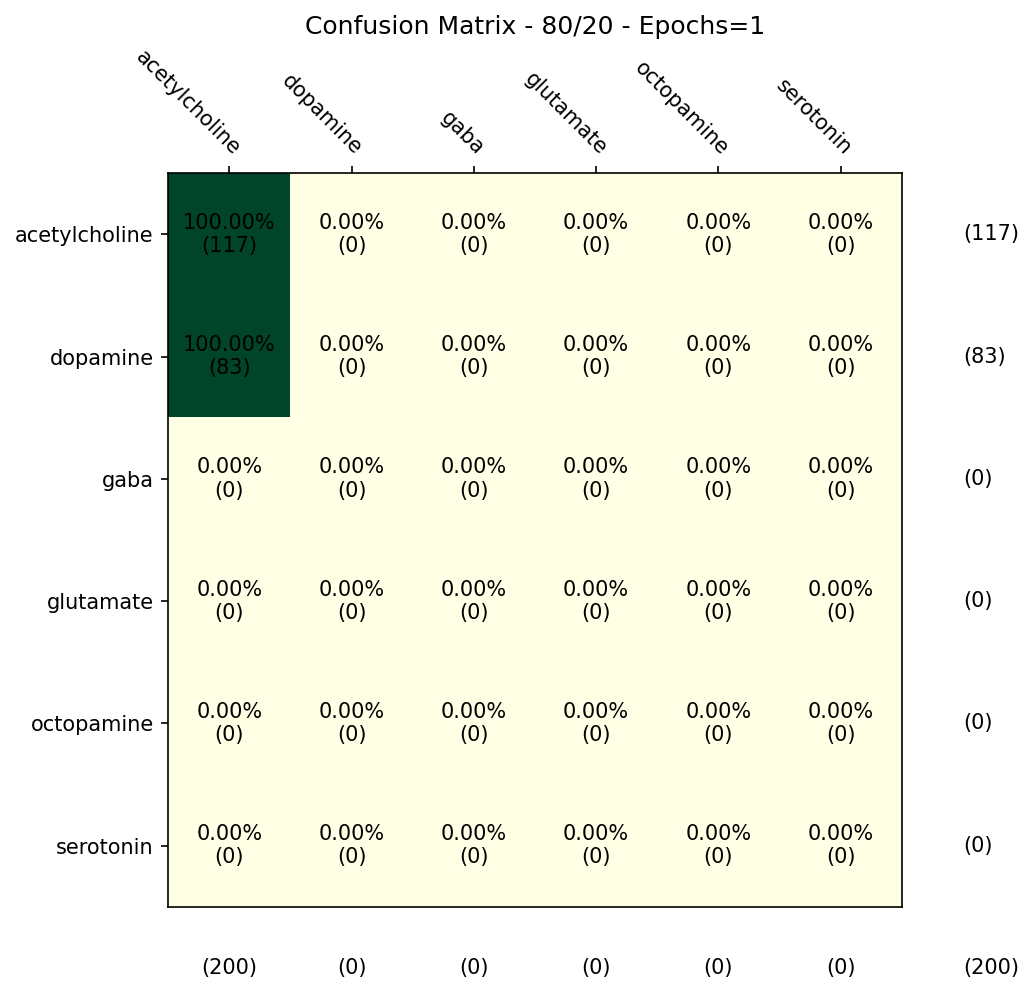

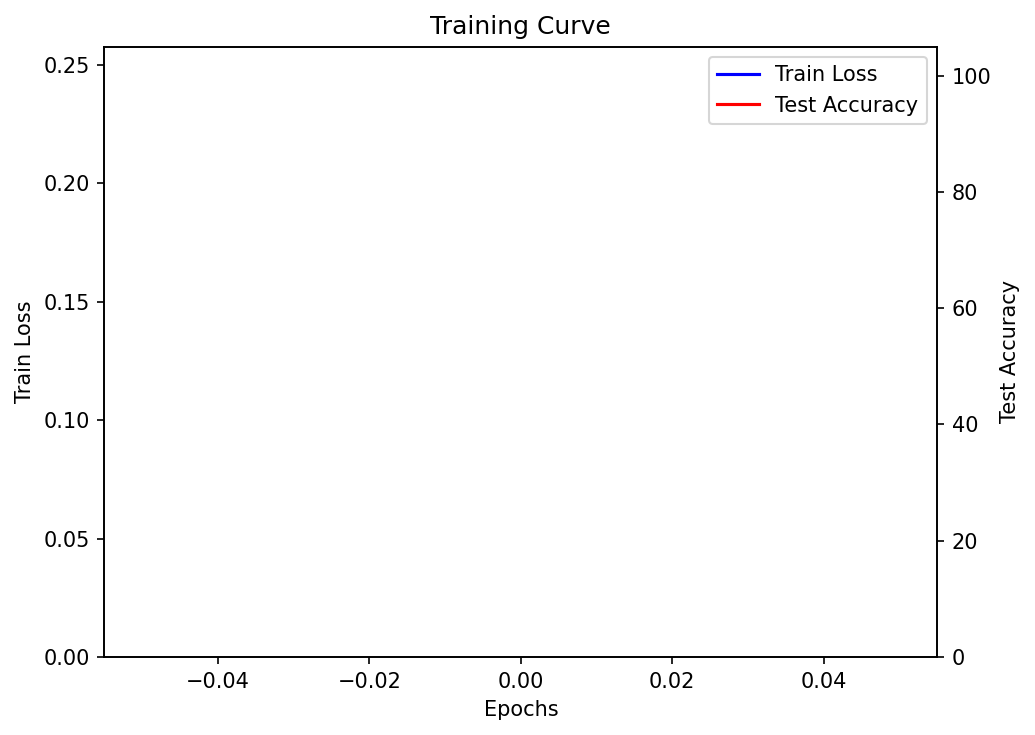

In [3]:
from Fine_Tuning.display_results import class_proportions, confusion_matrix
#class_proportions('psd', prediction_list)
split = '80/20'
confusion_matrix('neuro', prediction_list, nb_epochs, split)

from Fine_Tuning.display_results import training_curve
training_curve(nb_epochs, loss_list, test_accuracies)